In [13]:
from facenet.align import detect_face
from scipy import misc
import tensorflow as tf
from facenet.facenet import load_model
import os
import cv2
import matplotlib.pyplot as plt
from facenet.facenet import prewhiten
from utilities import show
import glob
import numpy as np
%matplotlib inline

In [2]:
gpu_memory_fraction = 0.4
minsize = 50 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor
margin = 44
image_size = 160

In [3]:
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

In [7]:
def filter_faces(files):
    face_list = []
    for file in files:
        img = misc.imread(file, mode='RGB')
        img_size = np.asarray(img.shape)[0:2]
        face_locations, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
        if len(face_locations) > 0:
            # Using only the first face found. Can add all the faces in an image using another for loop here.
            det = np.squeeze(face_locations[0,0:4])
            bb = np.zeros(4, dtype=np.int32)
            bb[0] = np.maximum(det[0]-margin/2, 0)
            bb[1] = np.maximum(det[1]-margin/2, 0)
            bb[2] = np.minimum(det[2]+margin/2, img_size[1])
            bb[3] = np.minimum(det[3]+margin/2, img_size[0])
            cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
            aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
            prewhitened = prewhiten(aligned)
            face_list.append(prewhitened)
    return np.stack(face_list)

In [ ]:
dicaprio_single = filter_faces(['images/dicaprio-oscar.jpg'])
dicaprio_multiple = filter_faces(glob.glob('images/dicaprio/*'))
other_faces = filter_faces(glob.glob('images/people/*'))

In [10]:
decaprio_single.shape

(1, 160, 160, 3)

In [14]:
def calculate_embeddings(images):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            load_model('20180402-114759')
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            feed_dict = { images_placeholder: images, phase_train_placeholder:False }
            return sess.run(embeddings, feed_dict=feed_dict)

In [16]:
dicaprio_single_embeddings = calculate_embeddings(decaprio_single)

Model directory: 20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from 20180402-114759\model-20180402-114759.ckpt-275


In [15]:
dicaprio_multiple_embeddings = calculate_embeddings(decaprio_multiple)

Model directory: 20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from 20180402-114759\model-20180402-114759.ckpt-275


In [17]:
other_faces_embeddings = calculate_embeddings(other_faces)

Model directory: 20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from 20180402-114759\model-20180402-114759.ckpt-275


In [18]:
for embedding in dicaprio_multiple_embeddings:
    dist = np.sqrt(np.sum(np.square(np.subtract(dicaprio_single_embeddings, embedding))))
    print('  %1.4f  ' % dist, end='')

  0.6765    0.7066    0.8416    0.5882    0.8592    0.7961    0.9884    1.1765    0.5360    0.8113    0.5840    0.9264  

In [19]:
for embedding in other_faces_embeddings:
    dist = np.sqrt(np.sum(np.square(np.subtract(dicaprio_single_embeddings, embedding))))
    print('  %1.4f  ' % dist, end='')

  1.2496    1.3338    1.2912    0.9646    1.2502    1.3718    1.6643    1.4974    1.4471    1.5174    1.4534    1.4079  

In [20]:
dicaprio_images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in glob.glob('images/dicaprio/*')]
other_images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in glob.glob('images/people/*')]

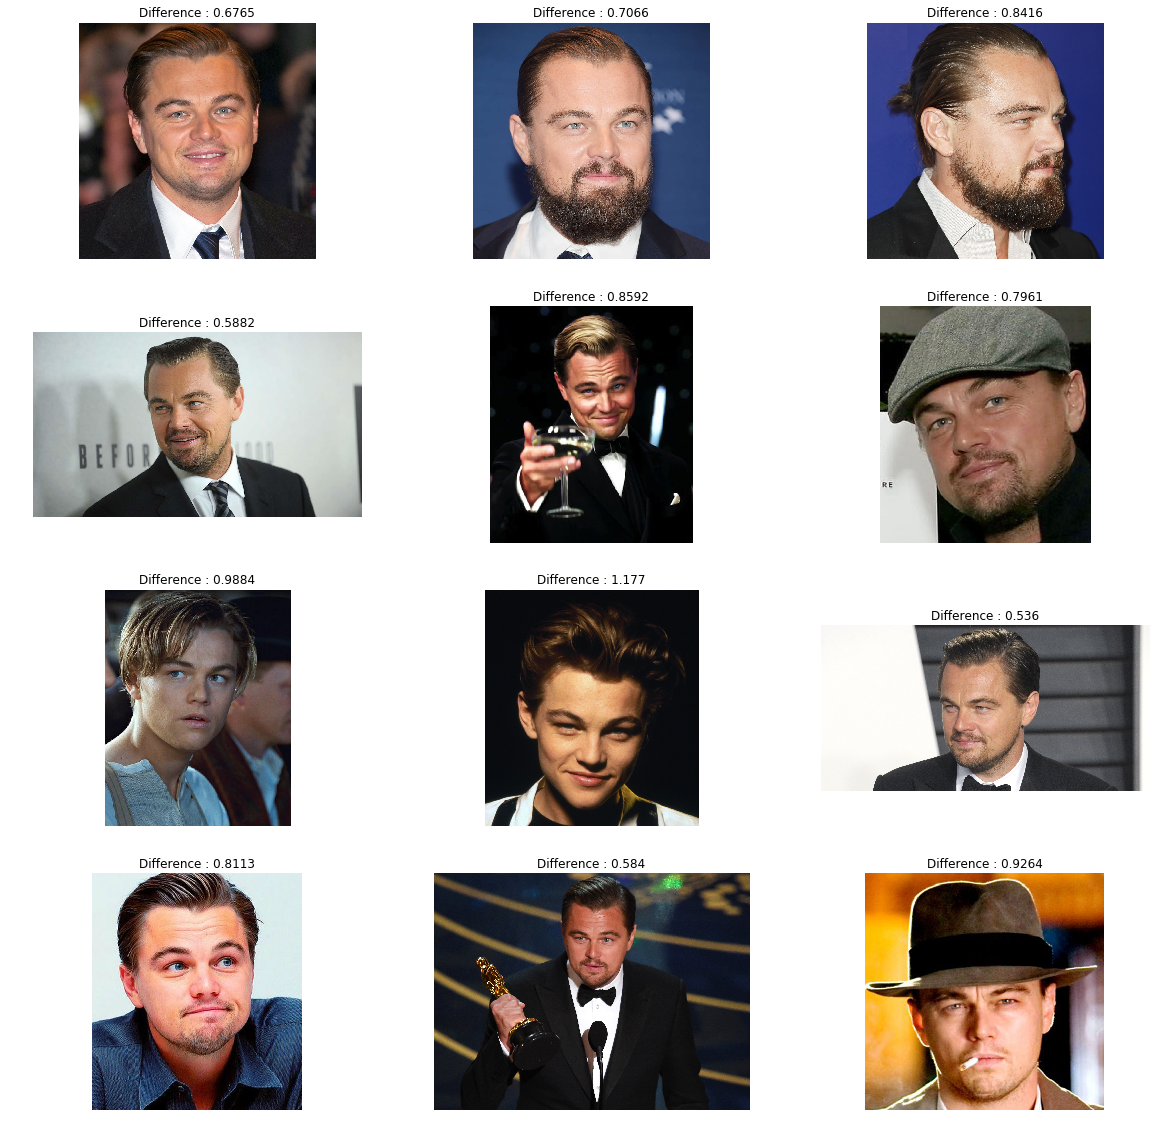

In [22]:
_, axarr = plt.subplots(4,3,figsize=(20, 20))
axa = axarr.reshape(-1)
for ax,img, embedding in zip(axa, dicaprio_images, dicaprio_multiple_embeddings):
    dist = np.sqrt(np.sum(np.square(np.subtract(dicaprio_single_embeddings, embedding))))
    current_plot = ax
    current_plot.axis('off')
    current_plot.imshow(img)
    current_plot.set_title('Difference : {:.4}'.format(dist))

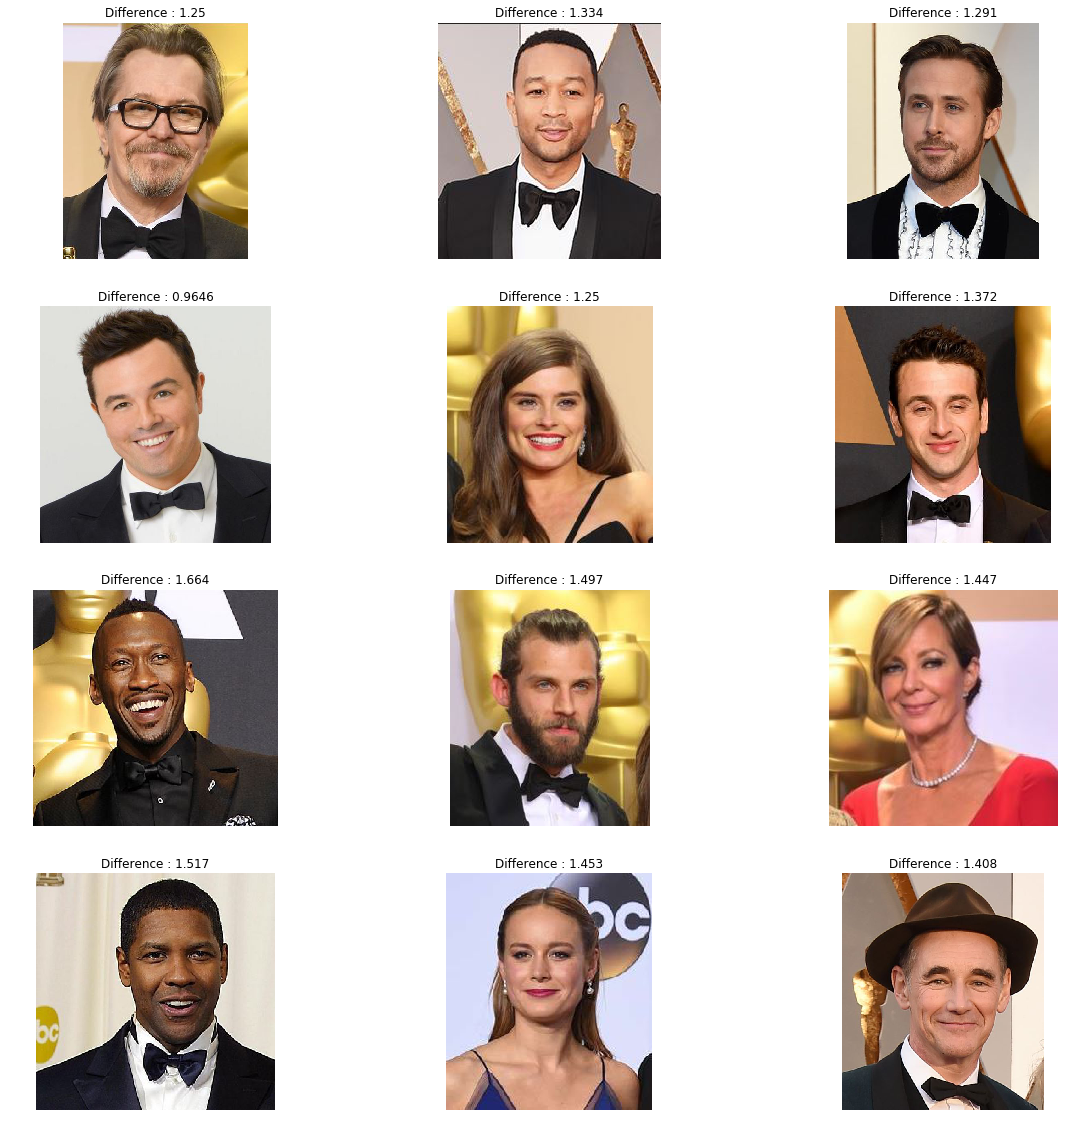

In [23]:
_, axarr = plt.subplots(4,3,figsize=(20, 20))
axa = axarr.reshape(-1)
for ax,img, embedding in zip(axa, other_images, other_faces_embeddings):
    dist = np.sqrt(np.sum(np.square(np.subtract(decaprio_single_embeddings, embedding))))
    current_plot = ax
    current_plot.axis('off')
    current_plot.imshow(img)
    current_plot.set_title('Difference : {:.4}'.format(dist))